In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

## Reading Data set

In [2]:
df = pd.read_csv('Subject_1_AL.csv') #Reading the data          

## Area Calculation

In [3]:
area_sqm = 6.2*0.3*10**(-6)

## Converting it to a stress vs strain curve

In [4]:
# Keep only necessary columns
df = df[['id', 'LOAD', 'ELONGATION']].copy()
df.rename(columns={'LOAD': 'Load', 'ELONGATION': 'Elongation'}, inplace=True)

df['Stress'] = (df['Load'] * 9.81 ) / area_sqm    # Stress = Load / Area in Pascals
df['Strain'] = df['Elongation'] / 39  # Strain = Change in length / Original length

# Remove the row with index 1
df = df.drop(index=0)

# Reset the index after dropping the row
df = df.reset_index(drop=True)
df['id'] = df['id'] - 1
df.head()

,id,Load,Elongation,Stress,Strain
0,1,0.231,0.0076,1.218339e+06,0.000195
1,2,1.035,0.0076,5.458790e+06,0.000195
2,3,2.322,0.0164,1.224668e+07,0.000421
3,4,3.931,0.0253,2.073285e+07,0.000649
4,5,5.620,0.0354,2.964097e+07,0.000908


## Plotting orignal data

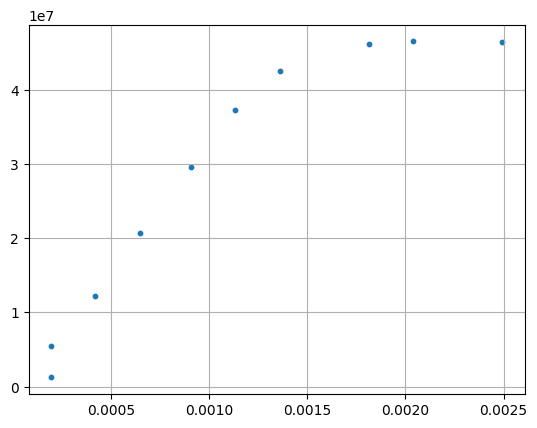

In [5]:
df = df[['Stress','Strain']]
plt.scatter(df['Strain'][:10],df['Stress'][:10],s=10)
plt.grid() # Plot of orignal data

## Neglecting first 15
 points as they form almost a flat line and ignoring last half of dataset as we need to find elestic limit

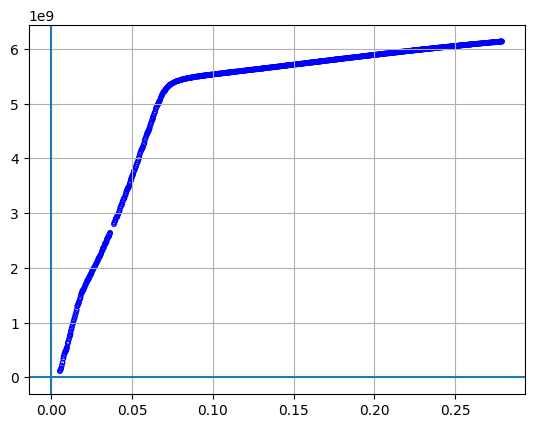

In [9]:
df2 = df[15:len(df)//2]
stress= df2['Stress'].to_numpy()
strain = df2['Strain'].to_numpy()
plt.grid()
plt.axhline()
plt.axvline()
plt.scatter(strain[:], stress[:], facecolors='none', edgecolors='blue', s=10, marker='o')


## Shifting the origin to the new datapoint

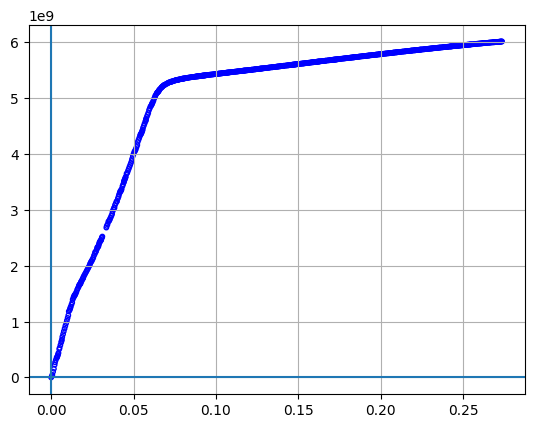

In [10]:
strain-=strain[0]
stress-=stress[0] # shifting the data points
plt.grid()
plt.axhline()
plt.axvline()
plt.scatter(strain[:], stress[:], facecolors='none', edgecolors='blue', s=10, marker='o')


## Computing the root mean square errors


In [11]:
(xi,yi) = strain[0],stress[0]
(xf,yf) = strain[-1],stress[-1]

def compute_rmse(arr1,arr2):
    return np.sqrt(np.mean((arr1-arr2)**2))

## linear fit ine and getting slope and intercept of the same

In [12]:
def linear_fit(x, y):
    m, c = np.polyfit(x, y, 1)
    
    def g(m_local, c_local, x_val):
        return m_local * x_val + c_local
    
    return m, c, g


## Calculating losses between actual point and corrosponding point on best fit line

In [13]:
losses = []
for i in range(2,len(strain)):
    mi1,ci1,gi1 = linear_fit(np.array(strain[:i]), np.array(stress[:i]) )
    loss_1 = compute_rmse(stress[:i], gi1(mi1,ci1,strain[:i]))
    losses.append(((mi1,ci1,loss_1),i))

## Sorting the losses in ascending order

In [14]:
l2 = losses[:]
l2.sort(key= lambda x: x[0][-1] )

## Plotting some graphs for linear fit

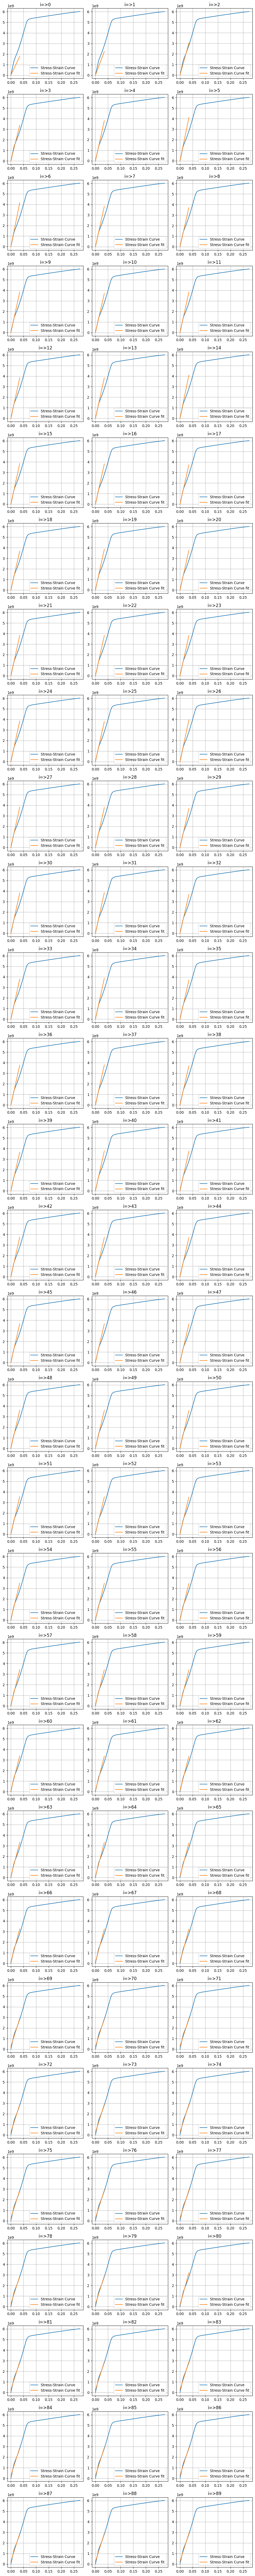

In [15]:
plt.figure(figsize=(10,100))
for i in range(1,91):
    mm,cc = l2[i-1][0][0], l2[i-1][0][1]
    plt.subplot(30,3,i)
    plt.plot(strain,stress, label="Stress-Strain Curve")
    plt.plot(strain[:100],mm*strain[:100] + cc, label="Stress-Strain Curve fit")
    plt.grid()
    plt.title(f'i=>{i-1}')
    plt.tight_layout()
    plt.legend()


plt.show()

## Code to make a video of all possible linear fits

In [16]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
fig, ax = plt.subplots(figsize=(10, 8))

# Set fixed limits based on the full dataset or your chosen limits.
fixed_xlim = (min(strain), max(strain))
fixed_ylim = (min(stress), max(stress))

# Set the fixed limits on the initial axes.
ax.set_xlim(fixed_xlim)
ax.set_ylim(fixed_ylim)

def update(i):
    # Clear the previous frame's content
    ax.cla()
    
    # Reapply the fixed limits since clearing removes them
    ax.set_xlim(fixed_xlim)
    ax.set_ylim(fixed_ylim)
    
    # Extract the fitting parameters for the current frame
    mm, cc = l2[i][0][0], l2[i][0][1]
    
    # Plot the full stress-strain curve
    ax.plot(strain, stress, label="Stress-Strain Curve")
    # Plot the linear fit for the first 100 points of strain
    ax.plot(strain[:100], mm * strain[:100] + cc, label="Stress-Strain Curve Fit")
    
    # Configure grid, title, and legend
    ax.grid(True)
    ax.set_title(f'Frame {i} (Index {i})')
    ax.legend()
    
    # Adjust layout if needed
    plt.tight_layout()

# Create the animation. Increase fps to 10 for a faster animation.
ani = animation.FuncAnimation(fig, update, frames=len(l2), repeat=False)

# Save the animation as an MP4 file using FFmpeg.
ani.save('animation__MS_3.mp4', writer='ffmpeg', fps=20)

# Optionally, display the animation in a window
HTML(ani.to_html5_video())
plt.close()


## Averaging the slope of the best fits

In [55]:
index1 = 220
index2 = 240
ar = l2[index1:index2+1]
mean_slope = np.mean([i[0][0] for i in ar])

## Young's Modulus

In [56]:
Y = float(mean_slope/(10**9))
print(f"{Y=} GPa")

Y=69.77077482225124 GPa


## Offsetting the line by 0.002 on strain axis

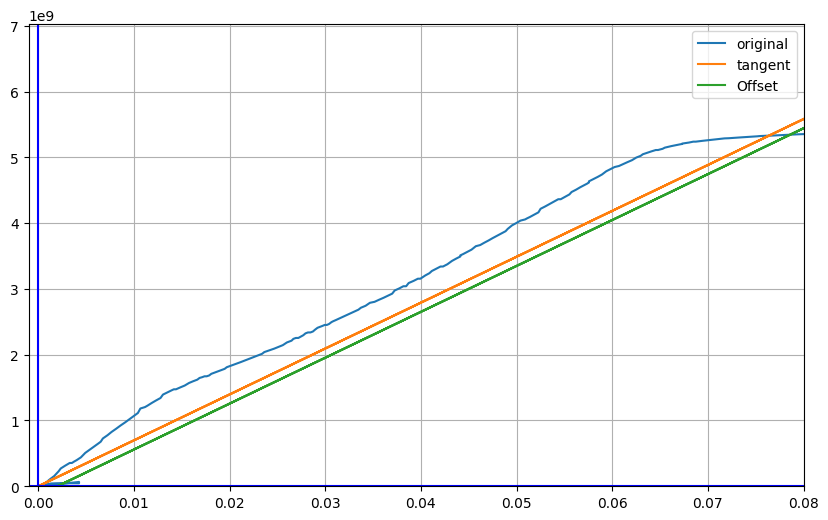

In [57]:
original_strain = df['Strain']
original_stress = df['Stress']

offset_line = (original_strain-0.002)*mean_slope
tangent_line = original_strain*mean_slope
plt.figure(figsize=(10,6))
plt.plot(original_strain,original_stress,label='original')
plt.plot(original_strain,tangent_line,label='tangent')
plt.plot(original_strain,offset_line,label='Offset')
plt.ylim(-1,1.1*max(original_stress))
plt.xlim(-0.001,0.08)
plt.legend()
plt.axhline(c='b')
plt.axvline(c='b')
plt.grid()

## Finding the point of intersection i.e yield strength

In [61]:
yeild_strain_idx = np.argmin(np.abs(offset_line-original_stress))
yeild_strength = original_stress[yeild_strain_idx]
float(yeild_strength)/10**6

5344.651500000001